# Identify interactions between odor and W_AIR representations in G4

In [1]:
%matplotlib inline
from copy import deepcopy
from itertools import product as cproduct
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, LinearRegression, Ridge

from aux import Generic
from data import DataLoader, random_chunk_split
from db import make_session, d_models
from lin_fit import fit_h_train_test, calc_r2
from plot import set_font_size, unity_line

import CONFIG as C

In [2]:
TRAIN_LEN = 39  # s
TEST_LEN = 1  # s

WDW = (-3, 1)

METHOD = 'built-in'
PARAMS = {
    'v_fwd': {'model': LinearRegression},
    'odor_binary': {'model': LinearRegression},
    'w_air': {'model': lambda: Lasso(alpha=0.5)},
    'air': {'model': LinearRegression},
}

BINS_AIR = np.linspace(-180, 180, 73)
MAX_AIR = 90

Linear models

In [3]:
class ModelVFS(object):
    
    name = 'VFS'
    
    def __init__(self, trial):
        
        # run odor_binary --> g4s fit
        self.rslt = fit_h_train_test(
            trial=trial,
            x_names=['v_fwd'],
            y_name='g4s',
            wdws={'v_fwd': WDW},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHOD,
            params=PARAMS['v_fwd'],
            normed=True,
            C=C)

In [4]:
class ModelOS(object):
    
    name = 'OS'
    
    def __init__(self, trial):
        
        # run odor_binary --> g4s fit
        self.rslt = fit_h_train_test(
            trial=trial,
            x_names=['odor_binary'],
            y_name='g4s',
            wdws={'odor_binary': WDW},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHOD,
            params=PARAMS['odor_binary'],
            normed=True,
            C=C)

In [5]:
class ModelOR(object):
    
    name = 'OR'
    
    def __init__(self, trial):
        
        # run odor_binary --> g4r fit
        self.rslt = fit_h_train_test(
            trial=trial,
            x_names=['odor_binary'],
            y_name='g4r',
            wdws={'odor_binary': WDW},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHOD,
            params=PARAMS['odor_binary'],
            normed=True,
            C=C)

In [6]:
class ModelOL(object):
    
    name = 'OL'
    
    def __init__(self, trial):
        
        # run odor_binary --> g4l fit
        self.rslt = fit_h_train_test(
            trial=trial,
            x_names=['odor_binary'],
            y_name='g4l',
            wdws={'odor_binary': WDW},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHOD,
            params=PARAMS['odor_binary'],
            normed=True,
            C=C)

In [7]:
class ModelW(object):
    
    name = 'W'
    
    def __init__(self, trial):
        
        # run w_air --> g4d fit
        self.rslt = fit_h_train_test(
            trial=trial,
            x_names=['w_air'],
            y_name='g4d',
            wdws={'w_air': WDW},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHOD,
            params=PARAMS['w_air'],
            normed=False,
            C=C,
            allow_nans=True)

In [8]:
class ModelA(object):
    
    name = 'A'
    
    def __init__(self, trial):
        
        # run air --> g4d fit
        self.rslt = fit_h_train_test(
            trial=trial,
            x_names=['air'],
            y_name='g4d',
            wdws={'air': WDW},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHOD,
            params=PARAMS['air'],
            normed=False,
            C=C,
            allow_nans=True)

In [9]:
MODEL_CLASSES = [ModelVFS, ModelOS, ModelOR, ModelOL, ModelW, ModelA]

# Define key functions

In [10]:
def load_trials(expt):
    
    # load trials
    session = make_session()
    trials = session.query(d_models.Trial).filter(
        d_models.Trial.expt == expt).all()
    session.close()

    # load data and create a moving average 
    for trial in trials:
        trial.dl = DataLoader(trial, 0, None)

        # nan out air and w_air for times when air is past threshold
        mask = np.abs(trial.dl.air) < MAX_AIR

        air, w_air = trial.dl.air, trial.dl.w_air

        air[~mask] = np.nan
        w_air[~mask] = np.nan

        trial.dl.data['AIR'] = air
        trial.dl.data['W_AIR'] = w_air
        
    return trials

In [11]:
def plot_air(trials):
    
    airs = np.concatenate([trial.dl.air for trial in trials])

    fig, ax = plt.subplots(1, 1, figsize=(10, 5), tight_layout=True)
    ax.hist(airs[~np.isnan(airs)], bins=BINS_AIR)

    ax.set_xlabel('Air tube position (deg)')
    ax.set_ylabel('Counts')

    set_font_size(ax, 16)

In [12]:
def fit_models(trials):

    models = {}

    for model_class in MODEL_CLASSES:

        models_ = {trial.name: model_class(trial) for trial in trials}
        models[model_class.name] = models_
        
    return models

In [13]:
def plot_y_vs_y_hat(trials, models):
    
    ax_h = 3
    
    ax_grid = (len(trials), len(models))

    fig_size = (20, ax_h*ax_grid[0])

    fig, axs = plt.subplots(*ax_grid, figsize=fig_size, tight_layout=True)

    r2s_train = {model_class.name: [] for model_class in MODEL_CLASSES}

    for trial, ax_row in zip(trials, axs):
        for model_class, ax in zip(MODEL_CLASSES, ax_row):

            model = models[model_class.name][trial.name]

            y = model.rslt.y
            y_hat_train = model.rslt.y_hat_train
            y_hat_test = model.rslt.y_hat_test
            r2_train = model.rslt.r2_train

            ax.scatter(y_hat_train, y, lw=0, c='gray', s=1)
            ax.scatter(y_hat_test, y, lw=0, c='k', s=8)

            unity_line(ax, *ax.get_xlim(), ls='--', zorder=-1)

            ax.grid()

            ax.set_title('{0}\n({1})\nR2 = {2:.4f}'.format(trial.name, model.name, r2_train))

            r2s_train[model_class.name].append(r2_train)

    for ax in axs.flatten():
        ax.set_xlabel('y_hat')
        ax.set_ylabel('y')
        set_font_size(ax, 16)
        
    return r2s_train

In [14]:
def plot_r2_scatters(r2s_train):
    
    fig, axs = plt.subplots(1, len(R2_SCATTERS), figsize=(15, 5), tight_layout=True, squeeze=False)
    axs = axs[0]

    for r2_scatter, ax in zip(R2_SCATTERS, axs):
        r2_x = r2s_train[r2_scatter[0]]
        r2_y = r2s_train[r2_scatter[1]]

        x_label = 'R2({})'.format(r2_scatter[2])
        y_label = 'R2({})'.format(r2_scatter[3])

        ax.scatter(r2_x, r2_y, c='k', lw=0)

        ax.set_xlim(-0.2, 0.8)
        ax.set_ylim(-0.2, 0.8)

        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)

        set_font_size(ax, 16)

In [15]:
def plot_r2s_bar(trials, models):
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 4), tight_layout=True)

    r2_mdns = []
    r2_stds = []

    for model_class in MODEL_CLASSES:

        r2s = []

        for trial in trials:
            model = models[model_class.name][trial.name]

            r2 = model.rslt.r2_train

            r2s.append(r2)

        r2_mdns.append(np.nanmedian(r2s))
        r2_stds.append(np.nanstd(r2s))

    x_bar = np.arange(len(r2_mdns))
    x_ticks = x_bar
    x_tick_labels = [model_class.name for model_class in MODEL_CLASSES]

    ax.bar(x_bar, r2_mdns, yerr=r2_stds, align='center')
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels)

    ax.axhline(0, color='gray', ls='--')
    ax.axvline(2.5, color='r', lw=2)

    ax.set_ylim(0, 1)
    
    ax.grid()

    ax.set_xlabel('Model Class')
    ax.set_ylabel('R2')

    set_font_size(ax, 16)

In [16]:
def plot_filters(trials, models):
    
    ax_h = 3.5
    
    ax_grid = (len(trials) + 1, len(models))
    
    fig_size = (20, ax_h*ax_grid[0])

    y_lims = {
        'VFS': (-0.2, 0.2),
        'OS': (-0.2, 0.2),
        'OR': (-0.2, 0.2),
        'OL': (-0.2, 0.2),
        'W': (-0.004, 0.0015),
        'A': (-0.01, 0.01),
    }

    fig, axs = plt.subplots(*ax_grid, figsize=fig_size, tight_layout=True)

    labels = [mc.name for mc in MODEL_CLASSES]

    t_hs = {label: [] for label in labels}
    hs = {label: [] for label in labels}

    # plot individual trial filters
    for trial, ax_row in zip(trials, axs):
        for ctr, ax in enumerate(ax_row):

            label = labels[ctr]
            model = models[label][trial.name]
            t_h = model.rslt.t_hs[model.rslt.x_names[0]]
            h = model.rslt.hs[model.rslt.x_names[0]]

            ax.plot(t_h, h, lw=2, c='k')
            ax.set_title('{}\n{}'.format(trial.name, label))

            t_hs[label].append(t_h)
            hs[label].append(h)

    # plot mean filters
    t_hs_mdn = {label: np.nanmedian(t_hs[label], 0) for label in labels}
    hs_mdn = {label: np.nanmedian(hs[label], 0) for label in labels}

    for label, ax in zip(labels, axs[-1, :]):

        ax.axhline(0, c='r', lw=2)
        ax.axvline(0, c='r', lw=2)

        ax.plot(t_hs_mdn[label], np.array(hs[label]).T, lw=0.5, color='gray')
        ax.plot(t_hs_mdn[label], hs_mdn[label], lw=3, color='k')

        ax.set_ylim(y_lims[label])

        ax.set_title(label)

    for ax in axs.flatten():

        ax.grid()

        ax.set_xlabel('t (s)')
        ax.set_ylabel('h')

        set_font_size(ax, 16)
        
    return hs_mdn

# Plot truth vs predicted G4X for each trial/model

In [17]:
R2_SCATTERS = [
    ('VFS', 'OS', 'v_fwd->g4s', 'odor->g4s'),
    ('OS', 'W', 'odor->g4s', 'w_air->g4d'),
    ('VFS', 'W', 'v_fwd->g4s', 'w_air->g4d'),
]

In [18]:
EXPT = 'white_odor_fluct'

In [19]:
trials = load_trials(EXPT)

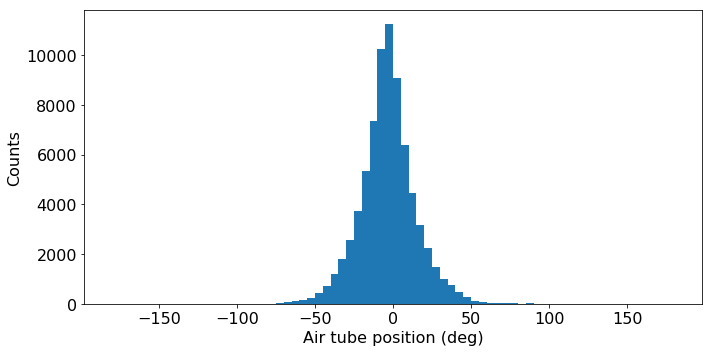

In [20]:
plot_air(trials)

In [21]:
models = fit_models(trials)

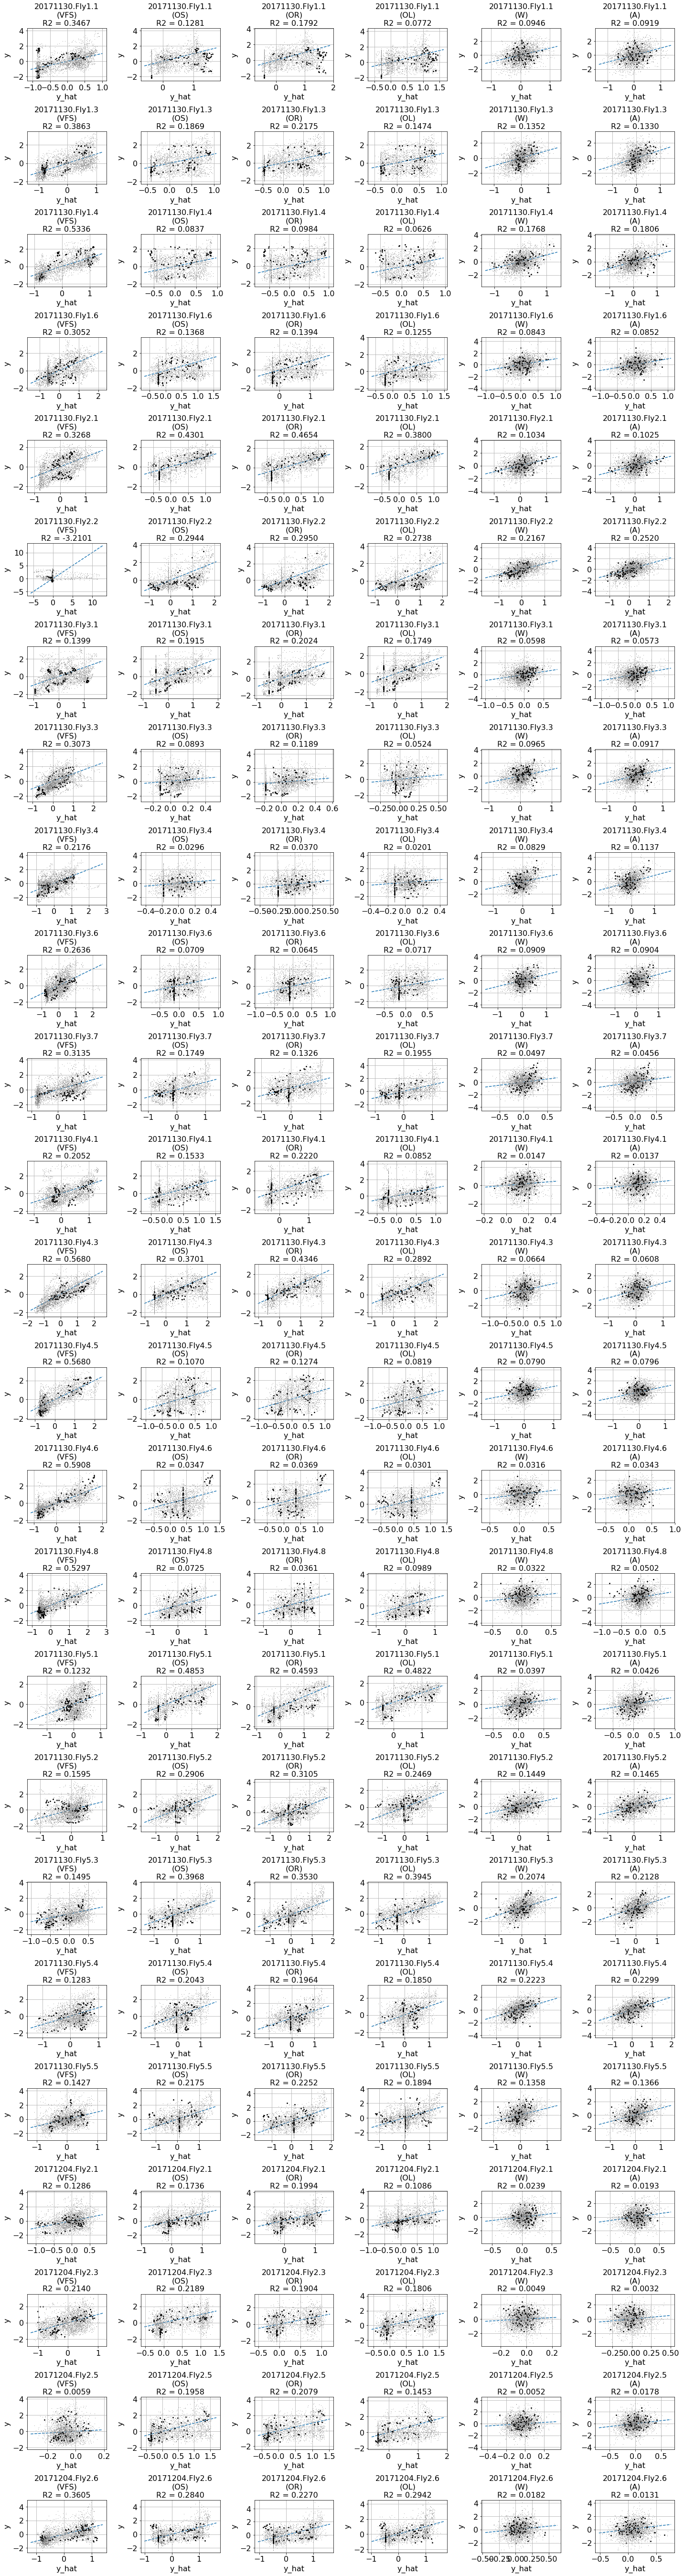

In [22]:
r2s_train = plot_y_vs_y_hat(trials, models)

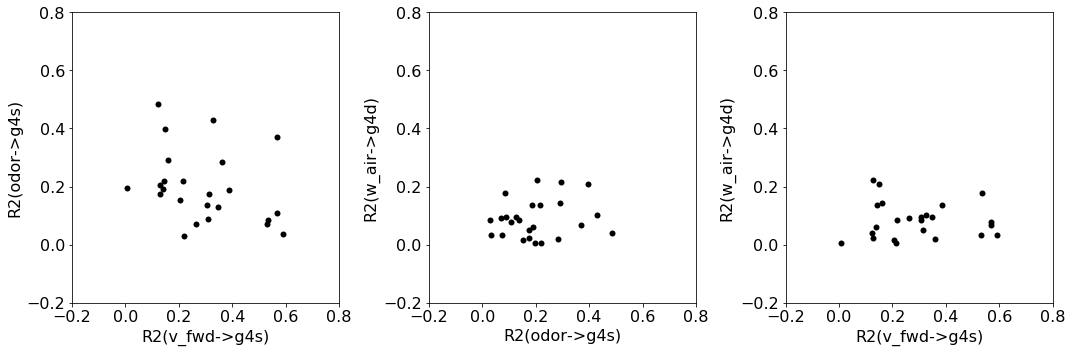

In [23]:
plot_r2_scatters(r2s_train)

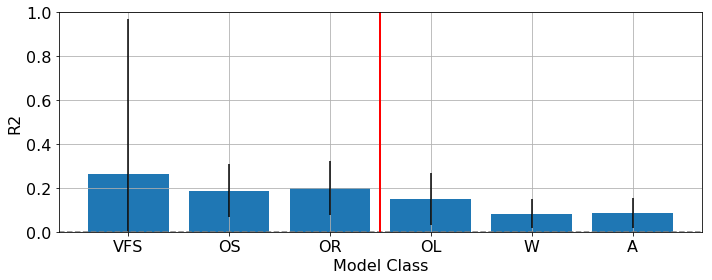

In [24]:
plot_r2s_bar(trials, models)

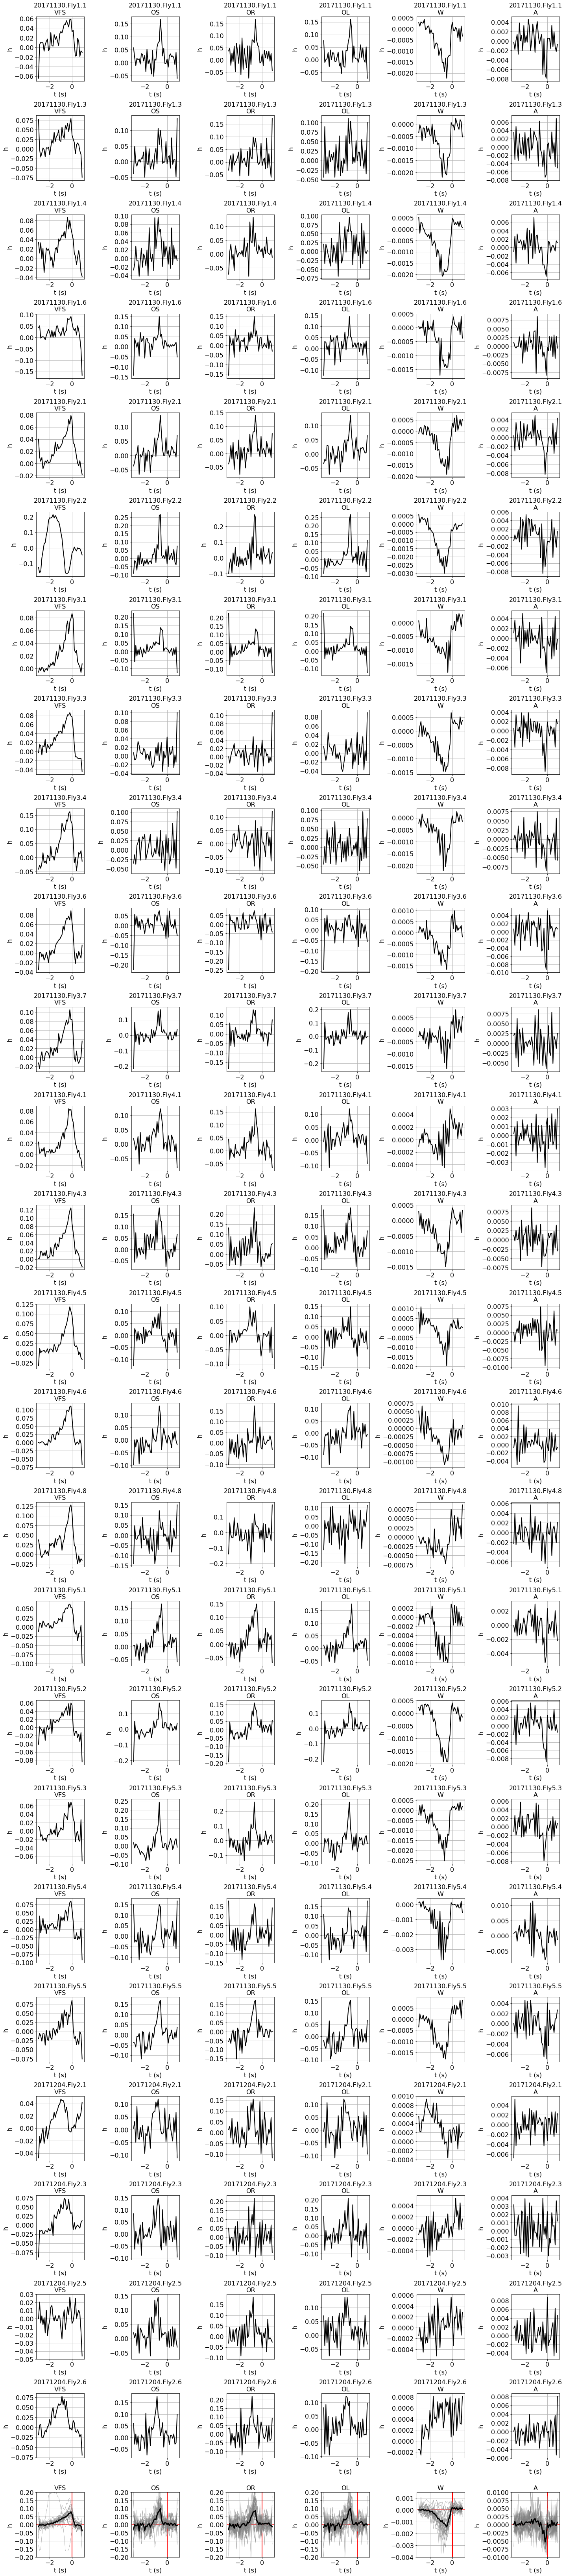

In [25]:
hs_mdn = plot_filters(trials, models)

# Interaction analysis

In [17]:
from data import random_shift

def fit_nested(x_1, x_2, y):
    """
    Fit nested interaction model and return coefs, rss.
    """
    # get interaction term
    x_12 = x_1 * x_2
    
    x = np.array([x_1, x_2, x_12]).T
    
    valid = np.all(~np.isnan(x), 1) & (~np.isnan(y))
    
    # fit null (non-interacting) model
    rgr_null = LinearRegression()
    rgr_null.fit(x[valid, :2], y[valid])
    
    y_hat_null = np.nan * np.zeros(len(y))
    y_hat_null[valid] = rgr_null.predict(x[valid, :2])
    
    r2_null = calc_r2(y, y_hat_null)
    
    coef_null = {
        'a_0': rgr_null.intercept_,
        'a_1': rgr_null.coef_[0],
        'a_2': rgr_null.coef_[1],
    }
    
    # fit interacting model
    rgr_iatn = LinearRegression()
    rgr_iatn.fit(x[valid, :], y[valid])
    
    y_hat_iatn = np.nan * np.zeros(len(y))
    y_hat_iatn[valid] = rgr_iatn.predict(x[valid, :])
    
    r2_iatn = calc_r2(y, y_hat_iatn)
    
    coef_iatn = {
        'a_0': rgr_iatn.intercept_,
        'a_1': rgr_iatn.coef_[0],
        'a_2': rgr_iatn.coef_[1],
        'a_12': rgr_iatn.coef_[2],
    }
    
    return Generic(
        r2_null=r2_null,
        coef_null=coef_null,
        r2_iatn=r2_iatn,
        coef_iatn=coef_iatn,
        rss=r2_iatn-r2_null)
    

def iatn_test(trial, x_name_1, x_name_2, y_name, n_shuffles, models, abbrevs):
    """
    Test for interactions between two sensorimotor representations in a given trial.
    
    :return: intcn_test_rslt instance with attributes:
        coef_null: {'a': ..., 'b_w': ..., 'b_o': ...}
        coef_iatn: {'a': ..., 'b_w': ..., 'b_o': ..., 'b_wo': ...}
        r2_null: R2 for non-interacting model
        r2_iatn: R2 for interacting model
        rss: residual sum of squares (how much better iatn model is than null model)
        rss_shuffled: shuffled rss values
        n_shuffles: how many shuffles used to calculate p-value
        p_val: p-value
    """
    
    xs = []
    
    for x_name in [x_name_1, x_name_2]:
        
        if x_name == 'w_air':
            
            # get w_air
            model_x = models['W'][trial.name]
            
        elif x_name == 'air':
            
            # get air
            model_x = models['A'][trial.name]
            
        elif x_name == 'odor_binary':
            
            # get odor binary
            model_x = models['OS'][trial.name]
            
        elif x_name == 'v_fwd':
            
            # get v_fwd
            model_x = models['VFS'][trial.name]
            
        else:
            
            raise Exception('No model found for x_name "{}".'.format(x_name))
            
        x = np.nan * np.zeros(len(trial.dl.t))

        x[model_x.rslt.train] = model_x.rslt.y_hat_train[model_x.rslt.train]
        x[model_x.rslt.test] = model_x.rslt.y_hat_test[model_x.rslt.test]
            
        xs.append(x)
        
    x_1, x_2 = xs
    
    if y_name == 'g4d':
        
        model_y = models['W'][trial.name]
        
    elif y_name == 'g4s':
        
        model_y = models['OS'][trial.name]
        
    elif y_name == 'g4r':
        
        model_y = models['OR'][trial.name]
        
    elif y_name == 'g4l':
        
        model_y = models['OL'][trial.name]
        
    y = model_y.rslt.y
    
    # fit nested models
    nested_rslt = fit_nested(x_1, x_2, y)
    
    # fit shuffled models
    rss_shuffled = np.nan * np.zeros(n_shuffles)
    r2_null_shuffled = np.nan * np.zeros(n_shuffles)
    r2_iatn_shuffled = np.nan * np.zeros(n_shuffles)
    
    for ctr in range(n_shuffles):
        
        x = np.array([x_1, x_2]).T
        x_1_shuffled, x_2_shuffled = random_shift(x).T
        
        nested_rslt_shuffled = fit_nested(x_1_shuffled, x_2_shuffled, y)
        
        rss_shuffled[ctr] = nested_rslt_shuffled.rss
        r2_null_shuffled[ctr] = nested_rslt_shuffled.r2_null
        r2_iatn_shuffled[ctr] = nested_rslt_shuffled.r2_iatn
        
    # calculate p-value
    p_val = np.mean(rss_shuffled >= nested_rslt.rss)
    
    coef_null = {
        'a_0': nested_rslt.coef_null['a_0'],
        'a_{}'.format(abbrevs[x_name_1]): nested_rslt.coef_null['a_1'],
        'a_{}'.format(abbrevs[x_name_2]): nested_rslt.coef_null['a_2'],
    }
    
    coef_iatn = {
        'a_0': nested_rslt.coef_iatn['a_0'],
        'a_{}'.format(abbrevs[x_name_1]): nested_rslt.coef_iatn['a_1'],
        'a_{}'.format(abbrevs[x_name_2]): nested_rslt.coef_iatn['a_2'],
        'a_{}{}'.format(abbrevs[x_name_1], abbrevs[x_name_2]): nested_rslt.coef_iatn['a_12'],
    }
    
    return Generic(
        coef_null=coef_null,
        coef_iatn=coef_iatn,
        r2_null=nested_rslt.r2_null,
        r2_iatn=nested_rslt.r2_iatn,
        rss=nested_rslt.rss,
        rss_shuffled=rss_shuffled,
        r2_null_shuffled=r2_null_shuffled,
        r2_iatn_shuffled=r2_iatn_shuffled,
        n_shuffles=n_shuffles,
        p_val=p_val)

$H_0: g4d(t) = a_0 + b_ww(t) + b_{vf}vf(t)$

$H_1: g4d(t) = a_0 + b_ww(t) + b_{vf}vf(t) + b_{wvf}w(t)vf(t)$

In [18]:
np.random.seed(0)

N_SHUFFLES = 2000

abbrevs = {'w_air': 'w', 'v_fwd': 'v'}

rslts_iatn = {
    trial.name: iatn_test(
        trial, 'w_air', 'v_fwd', 'g4d', N_SHUFFLES, models, abbrevs)
    for trial in trials
}

columns = ['R2_NULL', 'R2_IATN', 'RSS', 'P_VAL', 'COEF']

df = pd.DataFrame(columns=columns, index=[trial.name for trial in trials])

for trial_name, rslt_iatn in rslts_iatn.items():
    
    df.loc[trial_name]['R2_NULL'] = rslt_iatn.r2_null
    df.loc[trial_name]['R2_IATN'] = rslt_iatn.r2_iatn
    df.loc[trial_name]['RSS'] = rslt_iatn.rss
    df.loc[trial_name]['P_VAL'] = rslt_iatn.p_val
    
    df.loc[trial_name]['COEF'] = rslt_iatn.coef_iatn['a_wv']
    
df

,R2_NULL,R2_IATN,RSS,P_VAL,COEF
20171130.Fly1.1,0.121001,0.121021,2.03591e-05,0.914,-0.0267156
20171130.Fly1.3,0.170092,0.174777,0.00468459,0.055,0.311742
20171130.Fly1.4,0.183904,0.190666,0.00676221,0.056,0.322702
20171130.Fly1.6,0.0927017,0.0929959,0.000294192,0.6095,0.096511
20171130.Fly2.1,0.137776,0.139335,0.00155907,0.3425,-0.187797
20171130.Fly2.2,0.21561,0.218341,0.00273176,0.2965,0.0293866
20171130.Fly3.1,0.0601743,0.0613611,0.00118672,0.4145,0.248128
20171130.Fly3.3,0.0946581,0.0987656,0.00410744,0.0975,0.390214
20171130.Fly3.4,0.104031,0.106692,0.00266182,0.171,0.303148
20171130.Fly3.6,0.0956632,0.0975726,0.00190935,0.2165,-0.205


$H_0: g4d(t) = a_0 + b_ww(t) + b_oo(t)$

$H_1: g4d(t) = a_0 + b_ww(t) + b_oo(t) + b_{wo}w(t)o(t)$

In [19]:
np.random.seed(0)

N_SHUFFLES = 2000

abbrevs = {'w_air': 'w', 'odor_binary': 'o'}

rslts_iatn = {
    trial.name: iatn_test(
        trial, 'w_air', 'odor_binary', 'g4d', N_SHUFFLES, models, abbrevs)
    for trial in trials
}

columns = ['R2_NULL', 'R2_IATN', 'RSS', 'P_VAL', 'COEF']

df = pd.DataFrame(columns=columns, index=[trial.name for trial in trials])

for trial_name, rslt_iatn in rslts_iatn.items():
    
    df.loc[trial_name]['R2_NULL'] = rslt_iatn.r2_null
    df.loc[trial_name]['R2_IATN'] = rslt_iatn.r2_iatn
    df.loc[trial_name]['RSS'] = rslt_iatn.rss
    df.loc[trial_name]['P_VAL'] = rslt_iatn.p_val
    
    df.loc[trial_name]['COEF'] = rslt_iatn.coef_iatn['a_wo']
    
df

,R2_NULL,R2_IATN,RSS,P_VAL,COEF
20171130.Fly1.1,0.148487,0.149057,0.000570383,0.5425,-0.115263
20171130.Fly1.3,0.180656,0.180923,0.000267729,0.6505,-0.0932922
20171130.Fly1.4,0.190628,0.192994,0.00236575,0.2455,0.278382
20171130.Fly1.6,0.0851454,0.0854442,0.000298877,0.607,-0.120024
20171130.Fly2.1,0.131572,0.133084,0.0015127,0.326,0.229469
20171130.Fly2.2,0.216048,0.216105,5.70438e-05,0.8495,0.0218089
20171130.Fly3.1,0.0630894,0.0647209,0.00163144,0.2675,0.251842
20171130.Fly3.3,0.0942365,0.0946605,0.000423978,0.584,-0.375291
20171130.Fly3.4,0.0925869,0.0933397,0.00075277,0.42,-0.483523
20171130.Fly3.6,0.0925324,0.0933559,0.000823427,0.409,-0.243542


$H_0: g4r(t) = a_0 + b_ww(t) + b_oo(t)$

$H_1: g4r(t) = a_0 + b_ww(t) + b_oo(t) + b_{wo}w(t)o(t)$

In [20]:
np.random.seed(0)

N_SHUFFLES = 2000

abbrevs = {'w_air': 'w', 'odor_binary': 'o'}

rslts_iatn = {
    trial.name: iatn_test(
        trial, 'w_air', 'odor_binary', 'g4r', N_SHUFFLES, models, abbrevs)
    for trial in trials
}

columns = ['R2_NULL', 'R2_IATN', 'RSS', 'P_VAL', 'COEF']

df = pd.DataFrame(columns=columns, index=[trial.name for trial in trials])

for trial_name, rslt_iatn in rslts_iatn.items():
    
    df.loc[trial_name]['R2_NULL'] = rslt_iatn.r2_null
    df.loc[trial_name]['R2_IATN'] = rslt_iatn.r2_iatn
    df.loc[trial_name]['RSS'] = rslt_iatn.rss
    df.loc[trial_name]['P_VAL'] = rslt_iatn.p_val
    
    df.loc[trial_name]['COEF'] = rslt_iatn.coef_iatn['a_wo']
    
df

,R2_NULL,R2_IATN,RSS,P_VAL,COEF
20171130.Fly1.1,0.200105,0.21071,0.0106051,0.05,-0.490601
20171130.Fly1.3,0.215776,0.221315,0.00553869,0.095,0.426656
20171130.Fly1.4,0.140198,0.141123,0.000924349,0.4845,0.17463
20171130.Fly1.6,0.185332,0.186464,0.00113209,0.3525,-0.235667
20171130.Fly2.1,0.474608,0.474626,1.86045e-05,0.9305,0.0251778
20171130.Fly2.2,0.332356,0.335736,0.00338007,0.2185,-0.162288
20171130.Fly3.1,0.230027,0.234729,0.00470185,0.0895,0.430053
20171130.Fly3.3,0.155092,0.155631,0.000538611,0.5085,0.434604
20171130.Fly3.4,0.0574006,0.0574024,1.81243e-06,0.966,-0.0235737
20171130.Fly3.6,0.0993774,0.101086,0.00170816,0.3,-0.354349


$H_0: g4l(t) = a_0 + b_ww(t) + b_oo(t)$

$H_1: g4l(t) = a_0 + b_ww(t) + b_oo(t) + b_{wo}w(t)o(t)$

In [21]:
np.random.seed(0)

N_SHUFFLES = 2000

abbrevs = {'w_air': 'w', 'odor_binary': 'o'}

rslts_iatn = {
    trial.name: iatn_test(
        trial, 'w_air', 'odor_binary', 'g4l', N_SHUFFLES, models, abbrevs)
    for trial in trials
}

columns = ['R2_NULL', 'R2_IATN', 'RSS', 'P_VAL', 'COEF']

df = pd.DataFrame(columns=columns, index=[trial.name for trial in trials])

for trial_name, rslt_iatn in rslts_iatn.items():
    
    df.loc[trial_name]['R2_NULL'] = rslt_iatn.r2_null
    df.loc[trial_name]['R2_IATN'] = rslt_iatn.r2_iatn
    df.loc[trial_name]['RSS'] = rslt_iatn.rss
    df.loc[trial_name]['P_VAL'] = rslt_iatn.p_val
    
    df.loc[trial_name]['COEF'] = rslt_iatn.coef_iatn['a_wo']
    
df

,R2_NULL,R2_IATN,RSS,P_VAL,COEF
20171130.Fly1.1,0.129308,0.138339,0.00903068,0.0725,-0.448311
20171130.Fly1.3,0.153759,0.160103,0.00634356,0.0925,0.460069
20171130.Fly1.4,0.08351,0.0836278,0.00011777,0.7975,0.061458
20171130.Fly1.6,0.146125,0.146896,0.000771468,0.4235,-0.192654
20171130.Fly2.1,0.420474,0.420515,4.13451e-05,0.8855,-0.0373253
20171130.Fly2.2,0.323593,0.32722,0.0036261,0.217,-0.170304
20171130.Fly3.1,0.202489,0.20566,0.00317011,0.176,0.358279
20171130.Fly3.3,0.143006,0.143977,0.000970598,0.398,0.579045
20171130.Fly3.4,0.0205082,0.0206289,0.000120663,0.7255,0.191706
20171130.Fly3.6,0.0920801,0.0929752,0.000895057,0.44,-0.253398


$H_0: g4r(t) = a_0 + b_aa(t) + b_oo(t)$

$H_1: g4r(t) = a_0 + b_aa(t) + b_oo(t) + b_{ao}a(t)o(t)$

In [22]:
np.random.seed(0)

N_SHUFFLES = 2000

abbrevs = {'air': 'a', 'odor_binary': 'o'}

rslts_iatn = {
    trial.name: iatn_test(
        trial, 'air', 'odor_binary', 'g4r', N_SHUFFLES, models, abbrevs)
    for trial in trials
}

columns = ['R2_NULL', 'R2_IATN', 'RSS', 'P_VAL', 'COEF']

df = pd.DataFrame(columns=columns, index=[trial.name for trial in trials])

for trial_name, rslt_iatn in rslts_iatn.items():
    
    df.loc[trial_name]['R2_NULL'] = rslt_iatn.r2_null
    df.loc[trial_name]['R2_IATN'] = rslt_iatn.r2_iatn
    df.loc[trial_name]['RSS'] = rslt_iatn.rss
    df.loc[trial_name]['P_VAL'] = rslt_iatn.p_val
    
    df.loc[trial_name]['COEF'] = rslt_iatn.coef_iatn['a_ao']
    
df

,R2_NULL,R2_IATN,RSS,P_VAL,COEF
20171130.Fly1.1,0.199397,0.211864,0.0124669,0.043,-0.471722
20171130.Fly1.3,0.214516,0.221662,0.00714653,0.08,0.440201
20171130.Fly1.4,0.141138,0.142556,0.00141877,0.4285,0.19493
20171130.Fly1.6,0.18432,0.185594,0.0012734,0.378,-0.223517
20171130.Fly2.1,0.475408,0.47546,5.27218e-05,0.8905,0.0385099
20171130.Fly2.2,0.334991,0.3382,0.0032093,0.2775,-0.138045
20171130.Fly3.1,0.230684,0.234057,0.00337309,0.2145,0.283003
20171130.Fly3.3,0.151749,0.152255,0.000506454,0.6065,0.357981
20171130.Fly3.4,0.053361,0.0540909,0.000729984,0.5785,-0.35631
20171130.Fly3.6,0.0982992,0.101914,0.0036144,0.1555,-0.454663


$H_0: g4l(t) = a_0 + b_aa(t) + b_oo(t)$

$H_1: g4l(t) = a_0 + b_aa(t) + b_oo(t) + b_{ao}a(t)o(t)$

In [23]:
np.random.seed(0)

N_SHUFFLES = 2000

abbrevs = {'air': 'a', 'odor_binary': 'o'}

rslts_iatn = {
    trial.name: iatn_test(
        trial, 'air', 'odor_binary', 'g4l', N_SHUFFLES, models, abbrevs)
    for trial in trials
}

columns = ['R2_NULL', 'R2_IATN', 'RSS', 'P_VAL', 'COEF']

df = pd.DataFrame(columns=columns, index=[trial.name for trial in trials])

for trial_name, rslt_iatn in rslts_iatn.items():
    
    df.loc[trial_name]['R2_NULL'] = rslt_iatn.r2_null
    df.loc[trial_name]['R2_IATN'] = rslt_iatn.r2_iatn
    df.loc[trial_name]['RSS'] = rslt_iatn.rss
    df.loc[trial_name]['P_VAL'] = rslt_iatn.p_val
    
    df.loc[trial_name]['COEF'] = rslt_iatn.coef_iatn['a_ao']
    
df

,R2_NULL,R2_IATN,RSS,P_VAL,COEF
20171130.Fly1.1,0.129387,0.140598,0.0112112,0.0595,-0.442977
20171130.Fly1.3,0.156126,0.164053,0.00792638,0.0845,0.467114
20171130.Fly1.4,0.0834501,0.0837002,0.000250045,0.7375,0.0806847
20171130.Fly1.6,0.145767,0.146505,0.000737388,0.487,-0.168438
20171130.Fly2.1,0.423164,0.423183,1.86119e-05,0.904,0.0227539
20171130.Fly2.2,0.322967,0.326009,0.00304188,0.298,-0.136165
20171130.Fly3.1,0.202134,0.204043,0.00190851,0.358,0.215983
20171130.Fly3.3,0.145535,0.146414,0.00087927,0.5,0.468153
20171130.Fly3.4,0.019171,0.0194397,0.000268683,0.731,-0.215447
20171130.Fly3.6,0.0933273,0.0954225,0.00209512,0.261,-0.34197
